GT Fixed. 

In [ ]:
!git clone https://github.com/him4318/Transformer-ocr.git

Cloning into 'Transformer-ocr'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 96 (delta 38), reused 44 (delta 11), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [ ]:
%cd Transformer-ocr/

/content/Transformer-ocr


In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
%cd src/

[Errno 2] No such file or directory: 'src/'
/content


In [ ]:
!ls

data  engine.py  main.py  network


### 1.3 HDF5 files

Now, you'll run the *transform* function from **main.py**. For this, execute on **src** folder:

> ```python main.py --source=<DATASET_NAME> --transform```

Your data will be preprocess and encode, creating and saving in the **data** folder. Now your project directory will be like this:


```
.
├── data
│   ├── bentham.hdf5
│   ├── iam.hdf5
│   ├── rimes.hdf5
│   ├── saintgall.hdf5
│   └── washington.hdf5
├── raw
│   ├── bentham
│   │   ├── BenthamDatasetR0-GT
│   │   └── BenthamDatasetR0-Images
│   ├── iam
│   │   ├── ascii
│   │   ├── forms
│   │   ├── largeWriterIndependentTextLineRecognitionTask
│   │   ├── lines
│   │   └── xml
│   ├── rimes
│   │   ├── eval_2011
│   │   ├── eval_2011_annotated.xml
│   │   ├── training_2011
│   │   └── training_2011.xml
│   ├── saintgall
│   │   ├── data
│   │   ├── ground_truth
│   │   ├── README.txt
│   │   └── sets
│   └── washington
│       ├── data
│       ├── ground_truth
│       ├── README.txt
│       └── sets
└── src
    ├── data
    │   ├── evaluation.py
    │   ├── generator.py
    │   ├── preproc.py
    │   ├── reader.py
    ├── main.py
    ├── engine.py
    ├── network
    │   ├── model.py
    └── tutorial.ipynb

```

Then upload the **data** and **src** folders in the same directory in your Google Drive.

In [ ]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()

        # create ResNet-101 backbone
        self.backbone = resnet101()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

In [ ]:
"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""
import numpy

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source,charset, max_text_length, split, transform):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
        img = np.repeat(img[..., np.newaxis],3, -1)    
        img = pp.normalization(img)
        
        if self.transform is not None:
            img = self.transform(img)
            
        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size



class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", str(text,'UTF-8')).encode("ASCII", "ignore").decode("ASCII")

        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#bentham data set download link

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr" -O bentham.hdf5 && rm -rf /tmp/cookies.txt


--2022-07-01 13:46:25--  https://docs.google.com/uc?export=download&confirm=t&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr
Resolving docs.google.com (docs.google.com)... 142.251.12.139, 142.251.12.102, 142.251.12.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.12.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6lafdgl1pqs0q876npkdc1ej0b3gcjn6/1656683175000/11488128581626754426/*/1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr?e=download&uuid=7050d8ff-48a8-444f-ae2d-3a720023a025 [following]
--2022-07-01 13:46:27--  https://doc-0o-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6lafdgl1pqs0q876npkdc1ej0b3gcjn6/1656683175000/11488128581626754426/*/1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr?e=download&uuid=7050d8ff-48a8-444f-ae2d-3a720023a025
Resolving doc-0o-7s-docs.googleusercontent.com (doc-0o-7s-docs.googleusercontent.com)... 74.125.200.132, 

In [ ]:
import os
import datetime
import string

batch_size = 16
epochs = 20

# define paths
#change paths accordingly
source = 'bentham'
source_path = '/content/drive/MyDrive/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)



source: /content/drive/MyDrive/bentham.hdf5
output ../output/bentham
target ../output/bentham/checkpoint_weights_iam.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [ ]:
!ls

bentham.hdf5  data  engine.py  main.py	network


In [ ]:
import torchvision.transforms as T

device = torch.device("cuda")
transform = T.Compose([
    T.ToTensor()])
tokenizer = Tokenizer(charset_base)

train_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'train',transform), batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'valid',transform), batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


In [ ]:
criterion = LabelSmoothing(size=tokenizer.vocab_size, padding_idx=0, smoothing=0.1)
criterion.to(device)
lr = .0001 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def train(model, criterion, optimiser, scheduler,dataloader):
 
    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
          imgs = imgs.to(device)
          labels_y = labels_y.to(device)
    
          optimiser.zero_grad()
          output = model(imgs.float(),labels_y.long()[:,:-1])
 
          norm = (labels_y != 0).sum()
          loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
 
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
          optimizer.step()
          total_loss += loss.item() * norm
 
    return total_loss / len(dataloader)
 
def evaluate(model, criterion, dataloader,):
 
    model.eval()
    epoch_loss = 0
 
    with torch.no_grad():
      for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)
 
            output = model(imgs.float(),labels_y.long()[:,:-1])
              
            norm = (labels_y != 0).sum()
            loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
  
            epoch_loss += loss.item() * norm
 
    return epoch_loss / len(dataloader)

In [ ]:
#train model
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
 
best_valid_loss = np.inf
c = 0
for epoch in range(10):
 
    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()
 
    train_loss = train(model,  criterion, optimizer, scheduler, train_loader)
    valid_loss = evaluate(model, criterion, val_loader)
 
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
 
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), target_path)
        c=0
 
    if c>4:
        #decrease lr if loss does not deacrease after 5 steps
        scheduler.step()
        c=0
 
    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')

Epoch: 01 learning rate[0.0001]


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Time: 7m 51s
Train Loss: 1684.230
Val   Loss: 1529.294
Epoch: 02 learning rate[0.0001]
Time: 7m 58s
Train Loss: 1518.209
Val   Loss: 1369.879
Epoch: 03 learning rate[0.0001]
Time: 7m 57s
Train Loss: 1403.233
Val   Loss: 1269.810
Epoch: 04 learning rate[0.0001]
Time: 7m 56s
Train Loss: 1326.073
Val   Loss: 1201.490
Epoch: 05 learning rate[0.0001]
Time: 7m 56s
Train Loss: 1269.652
Val   Loss: 1160.032
Epoch: 06 learning rate[0.0001]
Time: 7m 57s
Train Loss: 1223.995
Val   Loss: 1120.092
Epoch: 07 learning rate[0.0001]
Time: 7m 57s
Train Loss: 1185.491
Val   Loss: 1085.868
Epoch: 08 learning rate[0.0001]
Time: 7m 57s
Train Loss: 1151.699
Val   Loss: 1062.792
Epoch: 09 learning rate[0.0001]
Time: 7m 56s
Train Loss: 1120.414
Val   Loss: 1037.184
Epoch: 10 learning rate[0.0001]
Time: 7m 56s
Train Loss: 1094.270
Val   Loss: 1012.779


You can download the trained model and run inference on it.
Below link downloads the model. Once model is downloaded you can move it to your google storage.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE" -O resnet_best.pt && rm -rf /tmp/cookies.txt


--2022-07-01 15:07:49--  https://docs.google.com/uc?export=download&confirm=t&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE
Resolving docs.google.com (docs.google.com)... 216.58.203.238, 2404:6800:4003:c0f::65, 2404:6800:4003:c0f::66, ...
Connecting to docs.google.com (docs.google.com)|216.58.203.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o84harrrh4uapkeh13lpk2nokitjr6pq/1656688050000/11488128581626754426/*/1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE?e=download&uuid=a7c268fb-21bb-4240-b4d3-67b2ccc63910 [following]
--2022-07-01 15:07:49--  https://doc-00-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o84harrrh4uapkeh13lpk2nokitjr6pq/1656688050000/11488128581626754426/*/1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE?e=download&uuid=a7c268fb-21bb-4240-b4d3-67b2ccc63910
Resolving doc-00-7s-docs.googleusercontent.com (doc-00-7s-docs.googleusercontent.com)... 

In [ ]:
#I trained my model with vocab length equal to 100
model = make_model(vocab_len=100)
_=model.to(device)

model.load_state_dict(torch.load('/content/Transformer-ocr/src/resnet_best.pt'))

<All keys matched successfully>

In [ ]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

In [ ]:
def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.cuda(), trg.cuda()            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to('cuda')
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
    return predicts, gt, imgs


In [ ]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'test',transform), batch_size=1, shuffle=False, num_workers=2)
predicts, gt, imgs = test(model, test_loader, max_text_length)

predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)
 
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))

Calculate Character Error Rate 0.2111822886879833, Word Error Rate 0.4326777171268724 and Sequence Error Rate 0.9560975609756097


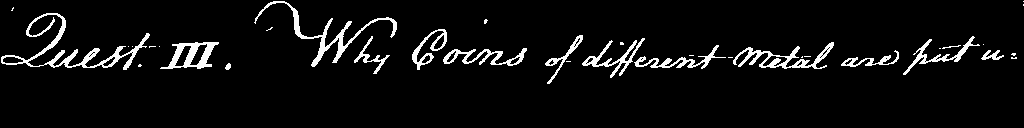

Ground truth: Quest . III . Why Coins of different Metal are put u
Prediction : Tuest II . Why Coins of disserent madare pat a 




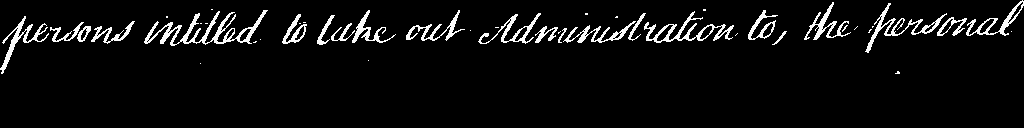

Ground truth: persons intitled to take out Administration to , the personal
Prediction : persons intitled to take out Administration to , the personal 




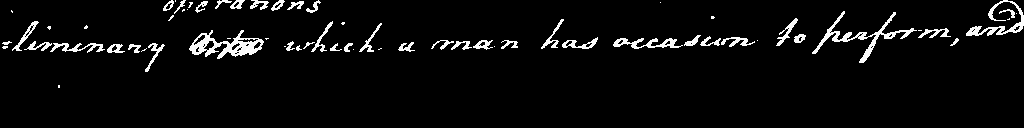

Ground truth: liminary Acts which a man has occasion to perform , and
Prediction : liminary " orde " which a man has occasion to perform , and 




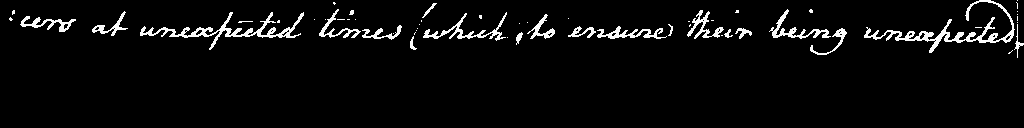

Ground truth: cers at unexpected times ( which , to ensure their being unexpected , 
Prediction : cers at uncepested times , which , to ensure their being unexpected 




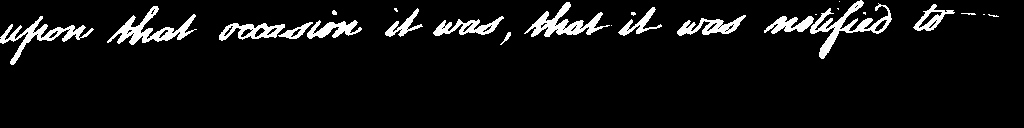

Ground truth: upon that occasion it was , that it was notified to
Prediction : apore that recrsion it ares , that it ares netfood to 




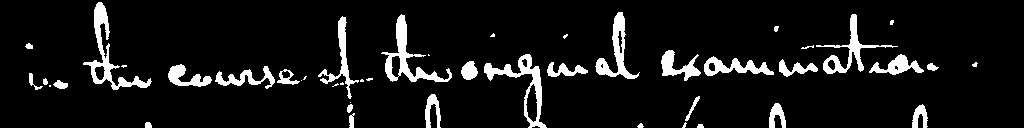

Ground truth: in the course of the original examination . 
Prediction : in the course of the onginal examination .  




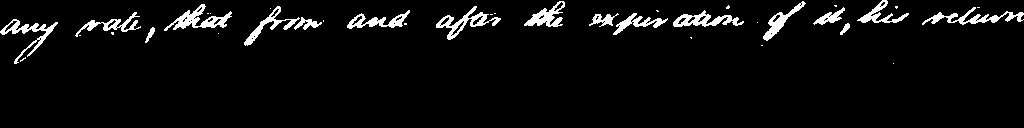

Ground truth: any rate , that from and after the expiration of it , his return
Prediction : any reate , that from and asser the expiration of d , his relaw 




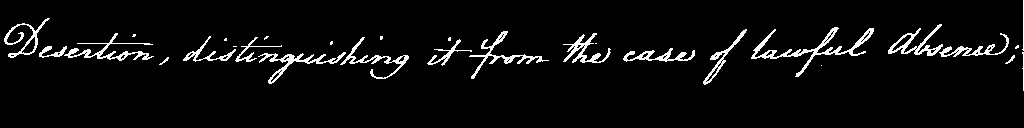

Ground truth: Desertion , distinguishing it from the case of lawful Absence ; 
Prediction : Desection , distinguishing it form the case of lawfal Uheonce ,  




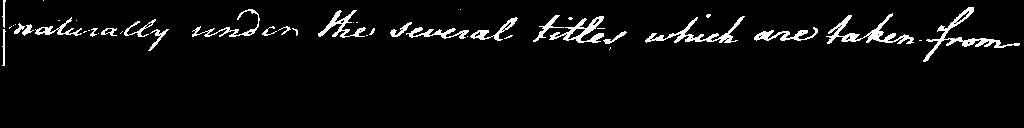

Ground truth: naturally under the several titles which are taken from
Prediction : raturalty under the several titles which are taken from 




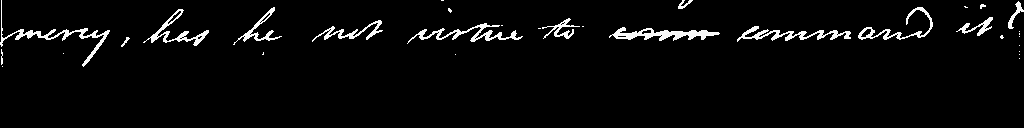

Ground truth: mercy , has he not virtue to comm command it ? 
Prediction : mercy , has he not isthue to command it .  




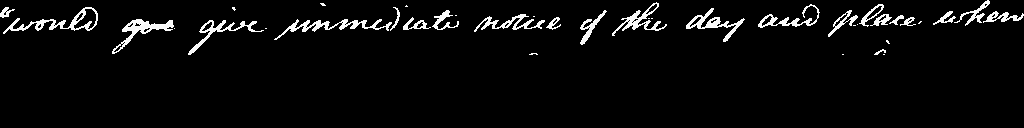

Ground truth:  " would get give immediate notice of the day and place when
Prediction : would gove give siministate notce of the day aud place athoon 




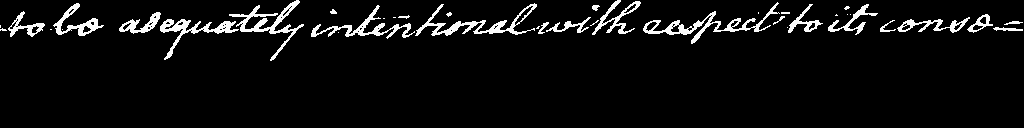

Ground truth: to be adequately intentional with respect to its conse - 
Prediction : to be adequately intentional with eapect toils conve 




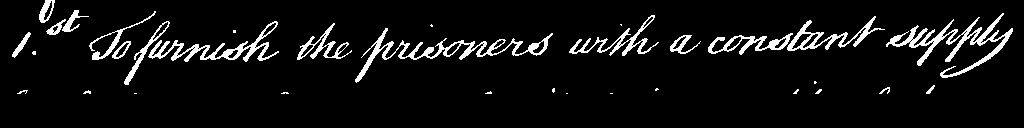

Ground truth: 1 . st To furnish the prisoners with a constant supply
Prediction : 1 . Exfamish the prisencers with a constant supsly 




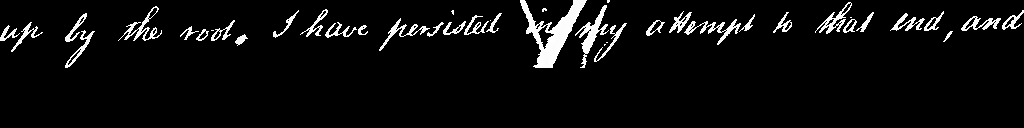

Ground truth: up by the root . I have persisted in my attempt to that end , and
Prediction :  - p by the rets Shave persicted indstely attempt to that ind , and 




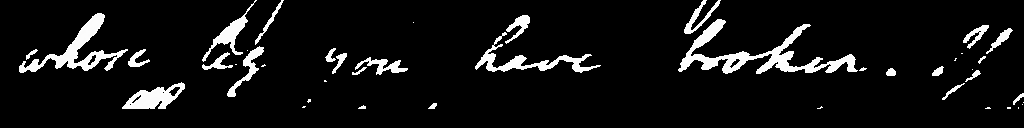

Ground truth: whose leg you have broken . If
Prediction : anlor to mhar hoken . &  




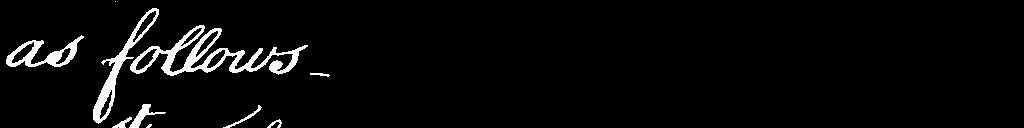

Ground truth: as follows
Prediction : as follows 




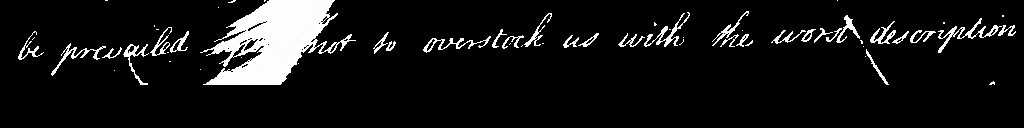

Ground truth: be prevailed upon not to overstock us with the worst description
Prediction : be prevaled gre not to ourstal as with the wout duscription 




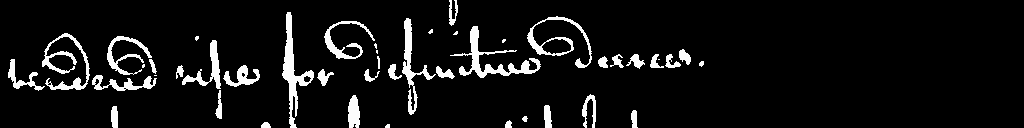

Ground truth: rendered ripe for definitive decrees . 
Prediction : rendoud rife for definiture ducrees .  




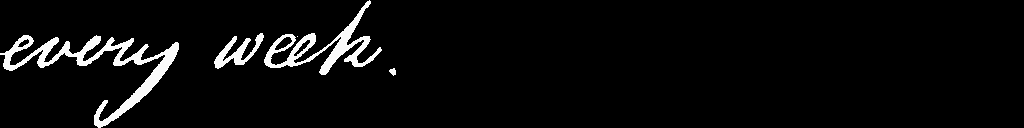

Ground truth: every week . 
Prediction : ens waks .  




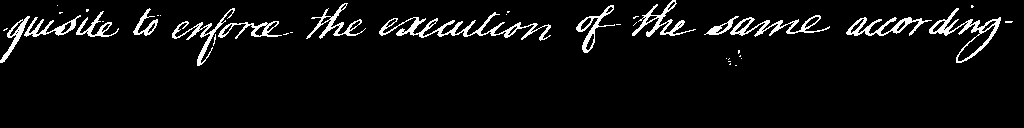

Ground truth:  - quisite to enforce the execution of the same according - 
Prediction : quisite to enfore the exercution of the same according 




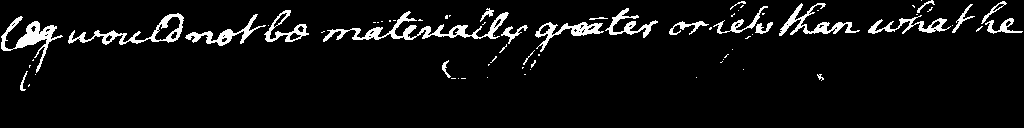

Ground truth: leg would not be materially greater or less than what he
Prediction : eg wouldnot be materialr grater or dely than what be 




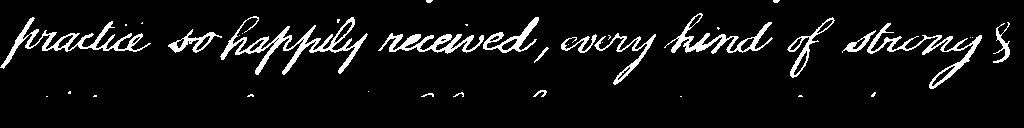

Ground truth: practice so happily received , every kind of strong & 
Prediction : practice so happly received , eveny hind of stuny ?  




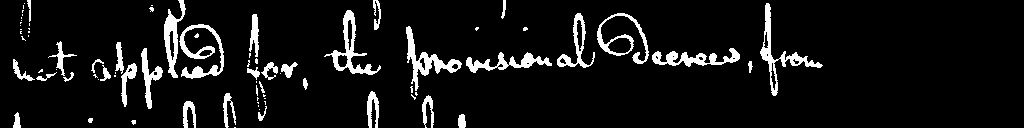

Ground truth: not applied for , the provisional decrees , from
Prediction :  " oppoled for , the provisional decrees , feen 




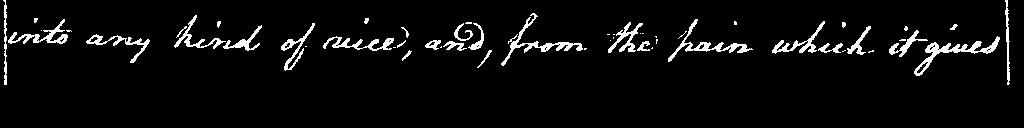

Ground truth: into any kind of vice , and , from the pain which it gives
Prediction : into any hind of vice , and from the pain which it gives ,  




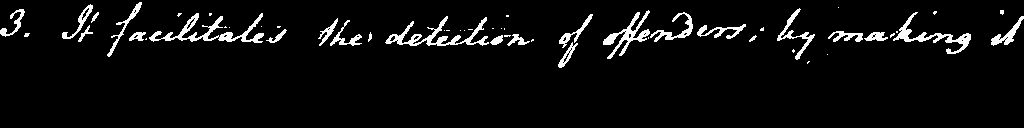

Ground truth: 3 . It facilitates the detection of offenders ; by making it
Prediction : 3 . A facilitates the detection of offenders , by making it 




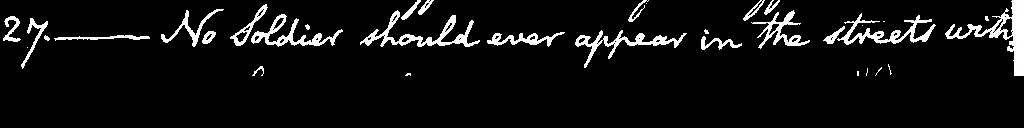

Ground truth: 27 . _ No soldier should ever appear in the streets with : 
Prediction : 87 . No Loldier should ever appear in the streets with 




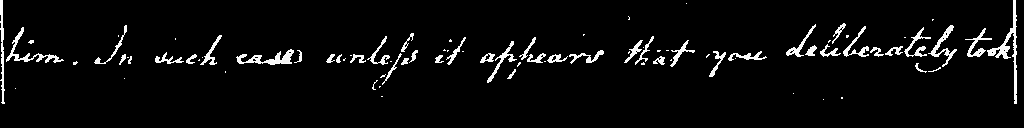

Ground truth: him . In such case unless it appears that you deliberately took
Prediction : tim . In such case unless it appears that you deliterately tool 




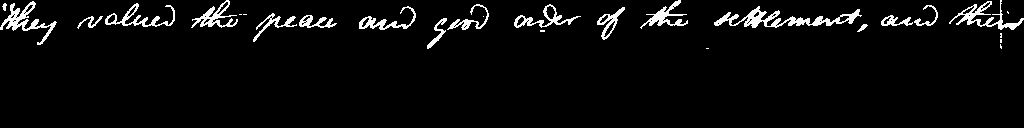

Ground truth:  " they valued the peace and good order of the settlement , and their
Prediction : they valued the yeace and good addr of the settiment , and thels 




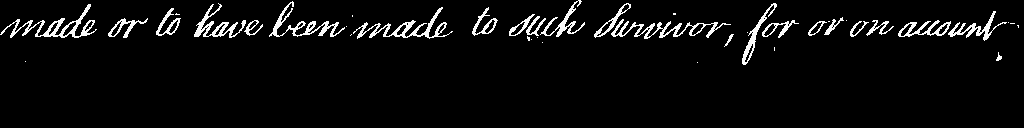

Ground truth: made or to have been made to such Survivor , for or on account
Prediction : male or to have been made to such Sturviver , for or on account 




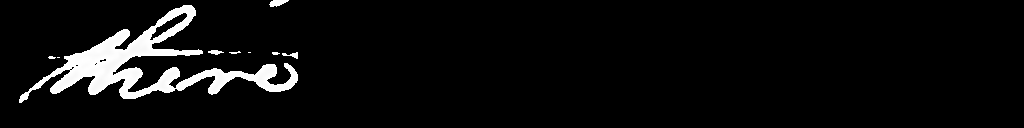

Ground truth: there
Prediction : thene 




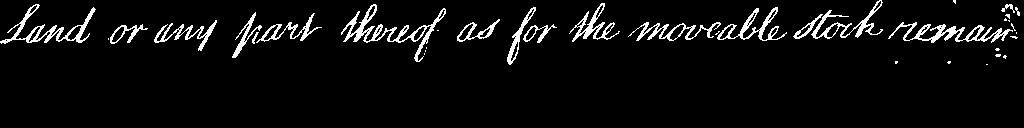

Ground truth: Land or any part thereof as for the moveable stock remain - 
Prediction : Land or any part thereof as for the moveable Ack reman 




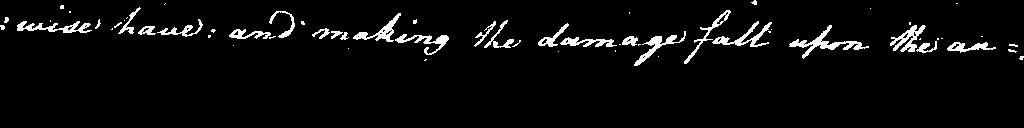

Ground truth: wise have : and making the damage fall upon the au
Prediction : wise have : and making the damage fall upon the ac :  




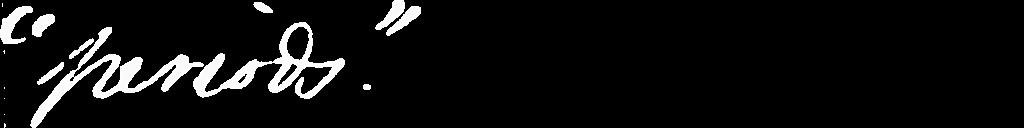

Ground truth:  " periods . 
Prediction :  " tansit .  




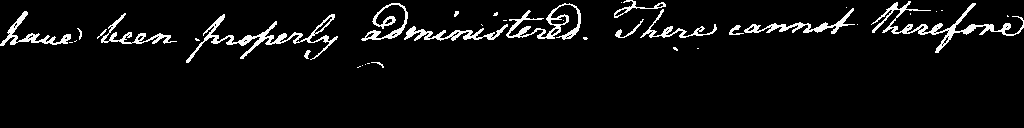

Ground truth: have been properly administered . There cannot therefore
Prediction : have been properly dministered . There cannot therefore 




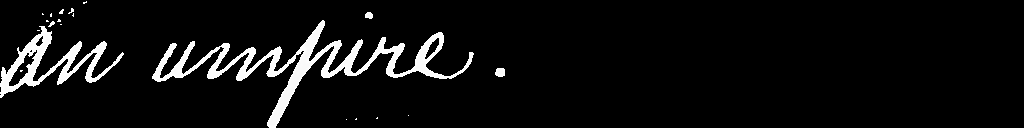

Ground truth: an umpire . 
Prediction : an ampire .  




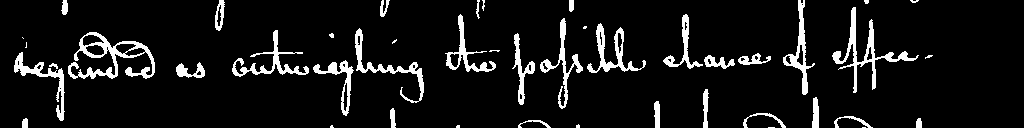

Ground truth: regarded as outweighing the possible chance of effec
Prediction : ceganded as cutwighing the possitly chause of offe 




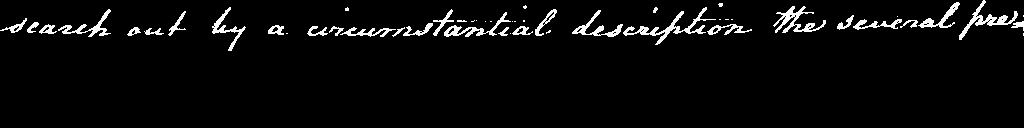

Ground truth: search out by a circumstantial description the several pre
Prediction : scarch out by a circumstantial desciption the sevenal pee 




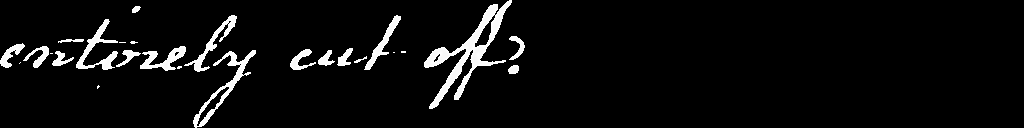

Ground truth: entirely cut off . 
Prediction : entirely cat of .  




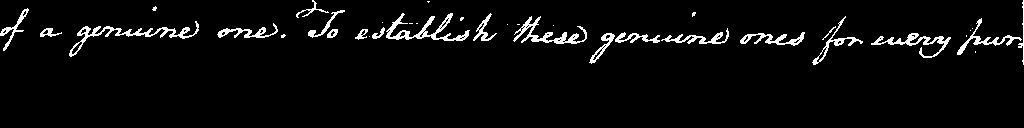

Ground truth: of a genuine one . To establish these genuine ones for every pur : 
Prediction : of a genuine one . To establish these gereuine ones for ewery pur 




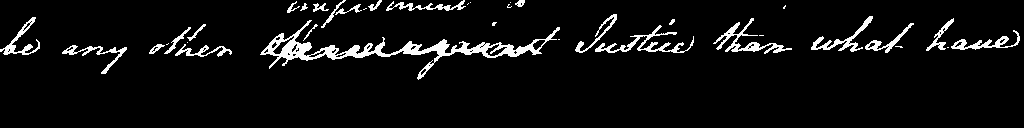

Ground truth: be any other offered against Justice than what have
Prediction : be any other ehicher Sustice than what have 




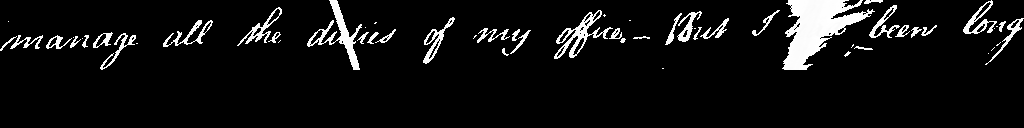

Ground truth: manage all the duties of my office - But I had been long
Prediction : manage all the detis of my offuse _ But Seal been Long 




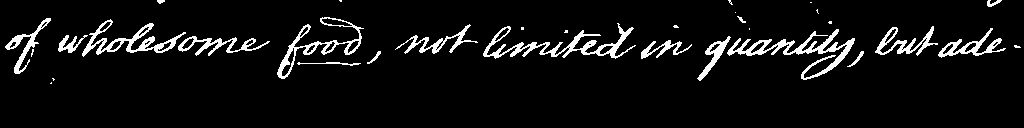

Ground truth: of wholesome food , not limited in quantity , but ade - 
Prediction : of wholesome food , not limited in quanity , lut ade 




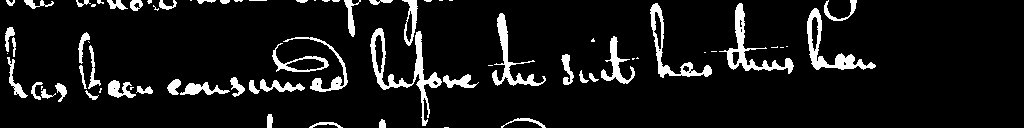

Ground truth: has been consumed before the suit has thus been
Prediction : las leen cousumed lifer the sut has heen 




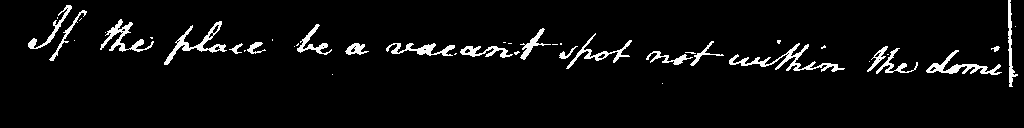

Ground truth: If the place be a vacant spot not within the domi
Prediction : It the place be a recant spot not within the domis 




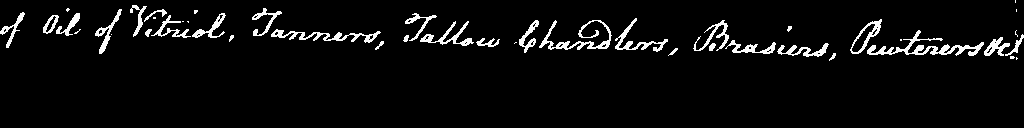

Ground truth: of Oil of Vitriol , Tanners , Tallow Chandlers , Brasiers , Pewterers & c . 
Prediction : of Ail of Knidl , Tanners , Tatters Lallow , Brasiers , Pecterers 




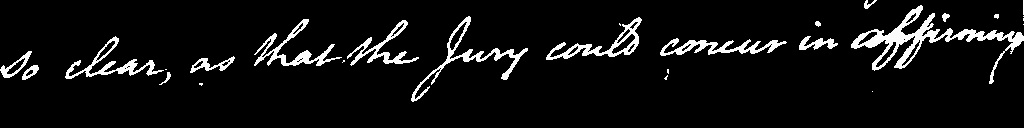

Ground truth: so clear , as that the Jury could concur in affirming
Prediction : so eleas , as that the Cury could comear in affiring 




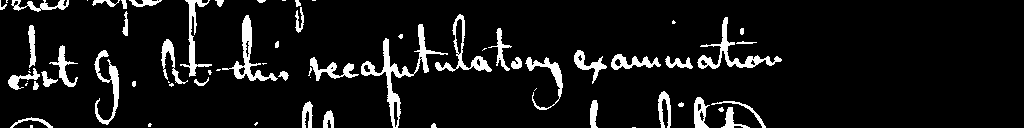

Ground truth: Art . 9 . At this recapitulatory examination
Prediction :  ' And . to this recapitatory examination 




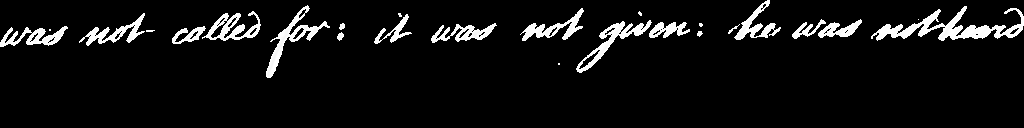

Ground truth: was not called for : it was not given : he was not heard
Prediction : as not alled for . it as not gison he ans not hur 




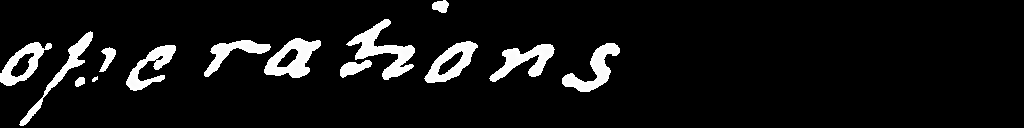

Ground truth: operations
Prediction : ousemen 




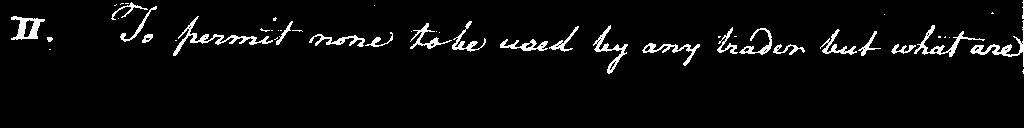

Ground truth: II . To permit none to be used by any trader but what are
Prediction : 2 . To permit none to be used by any teader but what are 




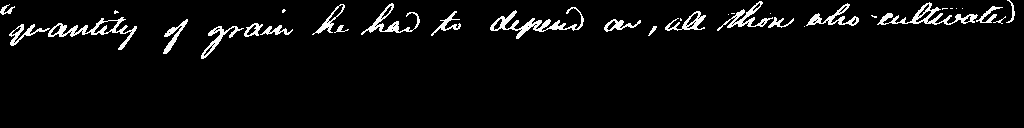

Ground truth:  " quantity of grain he had to depend on , all those who cultivated
Prediction :  " rantity of grain he had to depoud on , all thes als eultured 




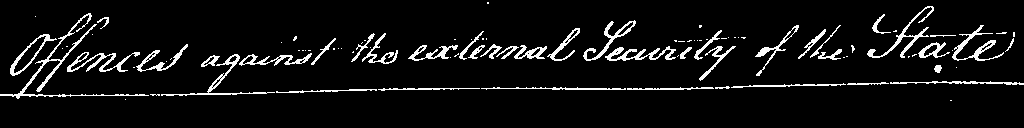

Ground truth: Offences against the external Security of the State . 
Prediction : Offences against the veternal Security of the State 




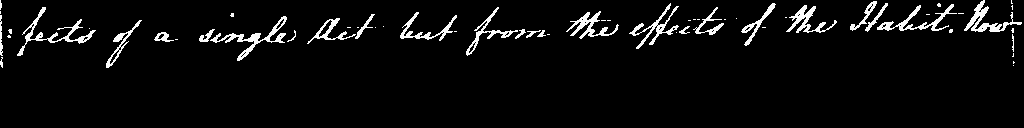

Ground truth: fects of a single Act but from the effects of the Habit . Now
Prediction : pets of a single Act but from the effects of the Stakid , low 




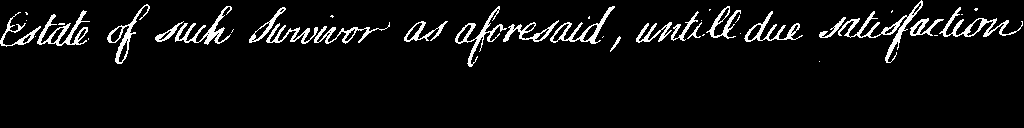

Ground truth: Estate of such Survivor as aforesaid , untill due satisfaction
Prediction : Estale of such Survivor as efresaid , untilled sation 




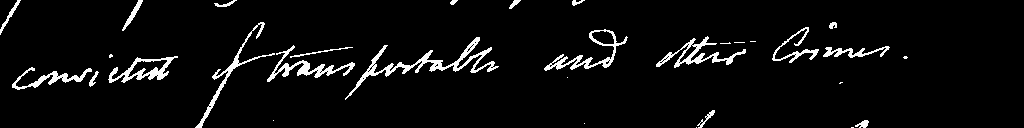

Ground truth: convicted of transportable and other Crimes . 
Prediction : consictet if taw bortall ind ther Priver .  




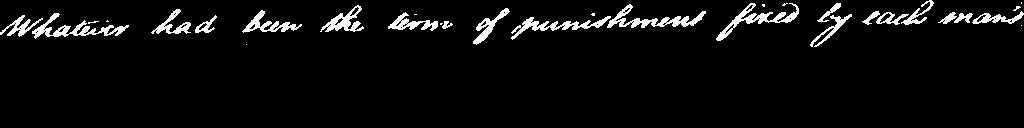

Ground truth: Whatever had been the term of punishment fixed by each man ' s
Prediction : Whatadver had Leen the term of sunistement fixed by caut mant 




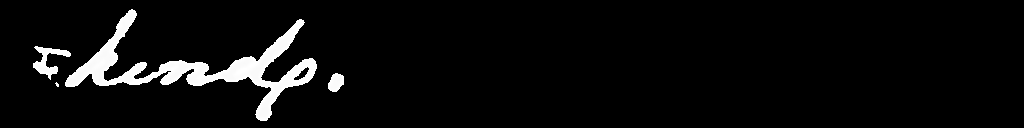

Ground truth: kind . 
Prediction :  - tendy .  




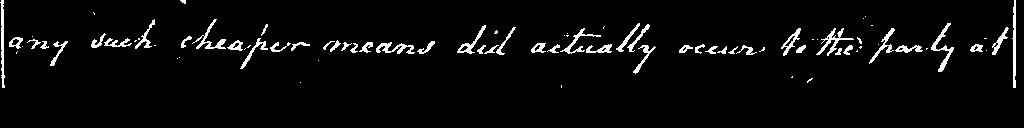

Ground truth: any such cheaper means did actually occur to the party at
Prediction : any such cheaper means dit actually occur to the parly at 




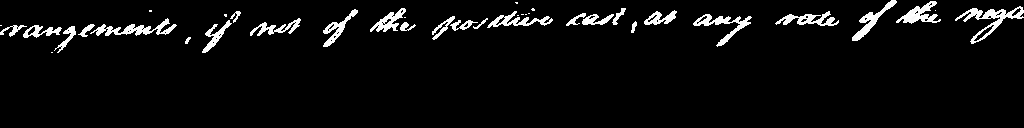

Ground truth:  - rangements , if not of the positive cast , at any rate of the negative
Prediction : ranjements , it not of the se itive cat , as any rate of the my 




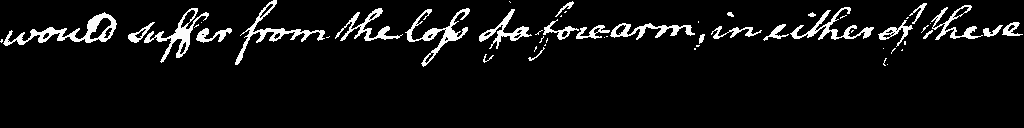

Ground truth: would suffer from the loss of a fore - arm , in either of these
Prediction : would suffer from the lod of fa forearn , in eitherof theso 




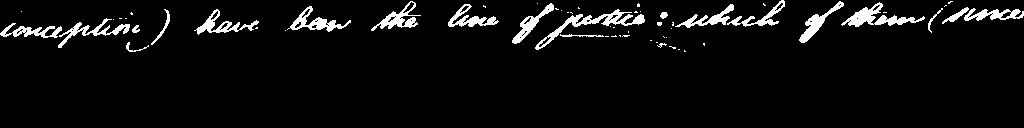

Ground truth: conception ) have been the line of justice : which of them ( since
Prediction : conerption ' s have Lon the line of qutice - which of thour & dsumesption 




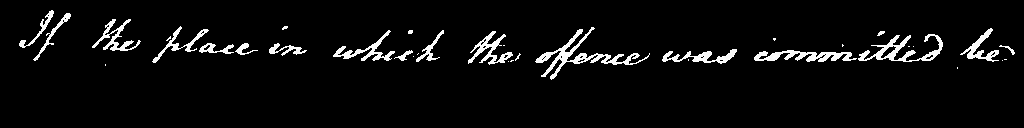

Ground truth: If the place in which the offence was committed be
Prediction : It the pace in which the offence was committed be 




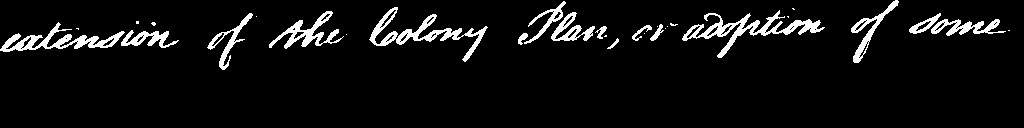

Ground truth: extension of the Colony Plan , or adoption of some
Prediction : atension of the Colony Har , or adption of dosise 




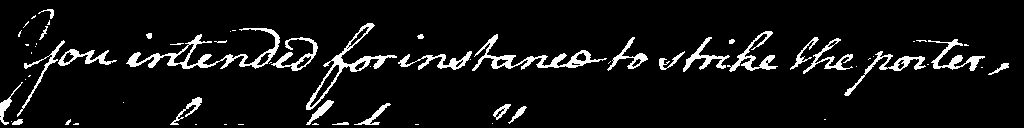

Ground truth: You intended for instance to strike the porter , 
Prediction : Force intended for instance to stike The porter 




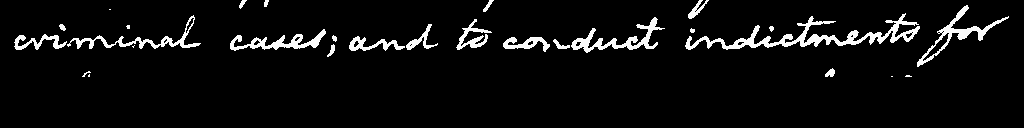

Ground truth: criminal cases ; and to conduct indictments for
Prediction : eriminal caises ; anot to conduct indictments for 




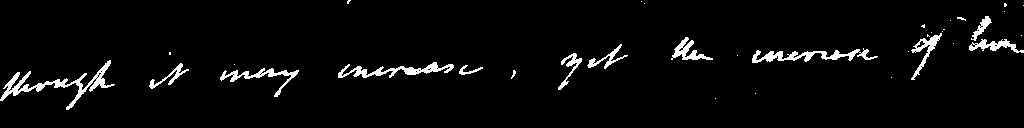

Ground truth: though it may increase , yet the increase of live
Prediction : shough it may innare , yet the cveniore of ho 




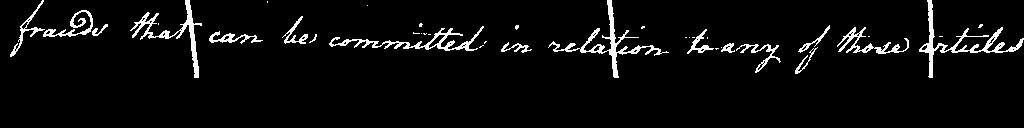

Ground truth: frauds that can be committed in relation to any of those articles
Prediction : frads that can be committed in relation to any of those fetites 




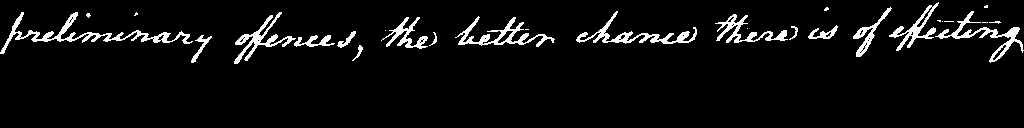

Ground truth: preliminary offences , the better chance there is of effecting
Prediction : preliminary offences , the better chance there is of offecting 




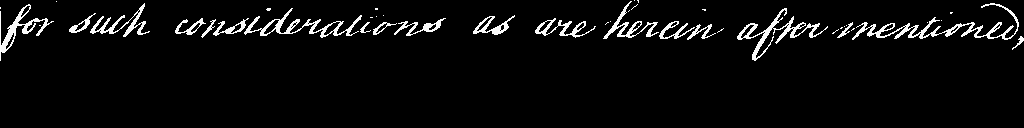

Ground truth: for such considerations as are herein after mentioned , 
Prediction : for such considerations as are herein asso mentioned 




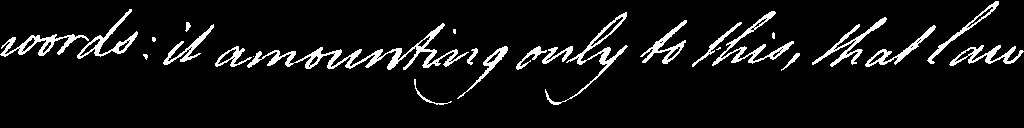

Ground truth: words : it amounting only to this , that law
Prediction : vonds : it amounting quly to this , that Tus 




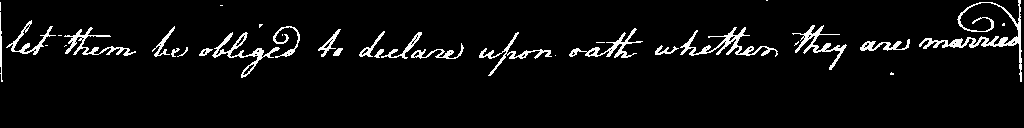

Ground truth: let them be obliged to declare upon oath whether they are married
Prediction : et them be ollyed to delare upon eath whether they are manid 




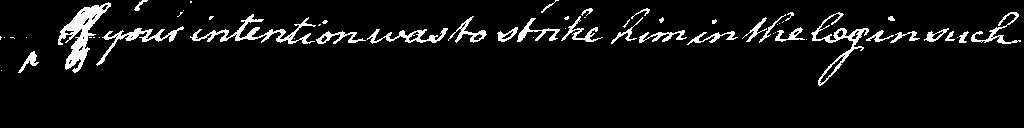

Ground truth: If your intention was to strike him in the leg in such
Prediction : of goue intertion wasto sthe Piminthelleginument 




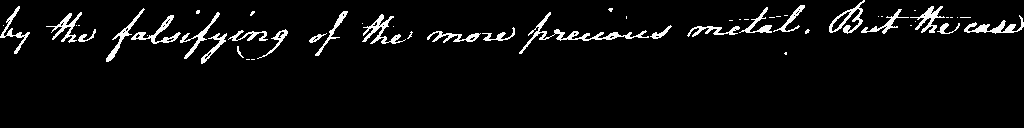

Ground truth: by the falsifying of the more precious metal . But the case
Prediction : by the falsing of the more precious melal . But the case 




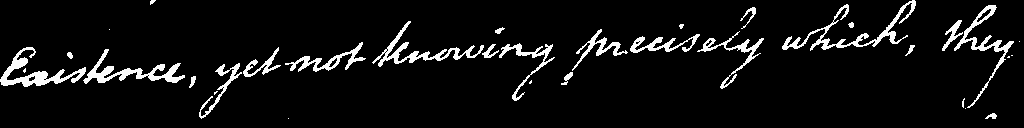

Ground truth: Existence , yet not knowing precisely which , they
Prediction : Eacintence , yet not lowing precisely which , they 




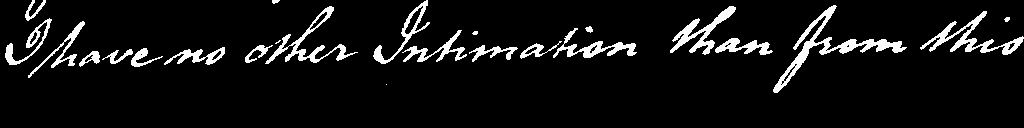

Ground truth: I have no other Intimation than from this
Prediction : Shave nes other Intimation than from this 




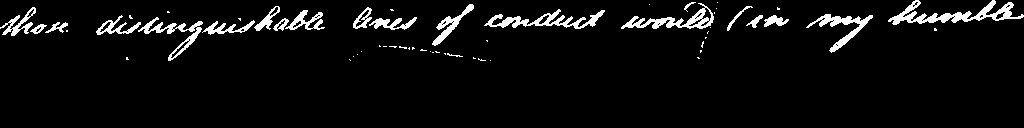

Ground truth: those distinguishable lines of conduct would ( in my humble
Prediction : those distinguishatle dines of conduct would bin my kunted 




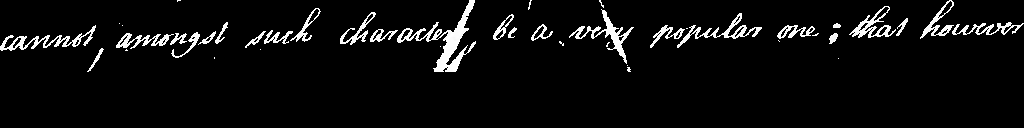

Ground truth: cannot , amongst such character be a very popular one ; that however
Prediction : cannent , anougst such charactes be a very expular one : that howevers 




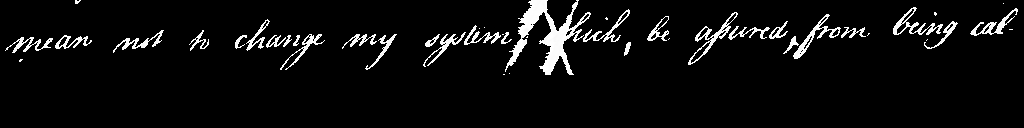

Ground truth: mean not to change my system ; which , be assured , from being cal - 
Prediction : mean not to charge my sgsteng & hich , be assured Gom being at 




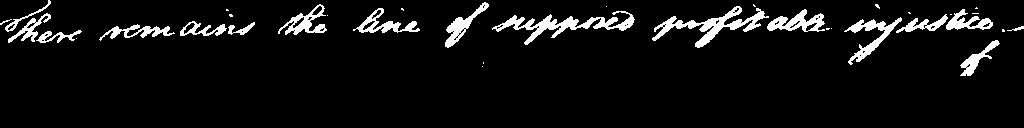

Ground truth: There remains the line of supposed profitable injustice
Prediction : there remains the lire of suppred quaste injutie .  




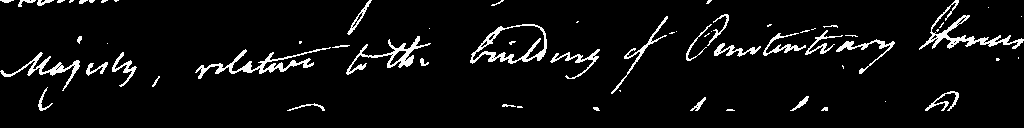

Ground truth: Majesty , relative to the building of Penitentiary Houses
Prediction : segisty , ndestive & the Puilding of Penitentrary Kence 




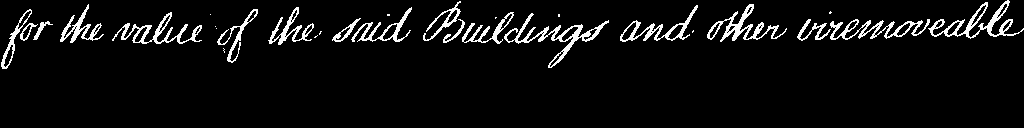

Ground truth: for the value of the said Buildings and other irremoveable
Prediction : for the nalue of the said Buildings and other incemoveable 




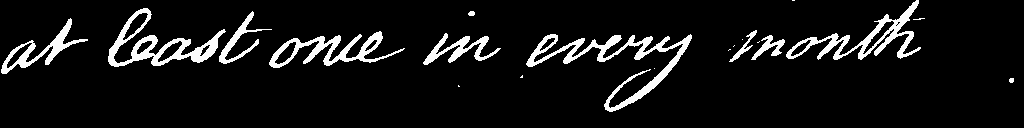

Ground truth: at least once in every month . 
Prediction : at Lawst one in month .  




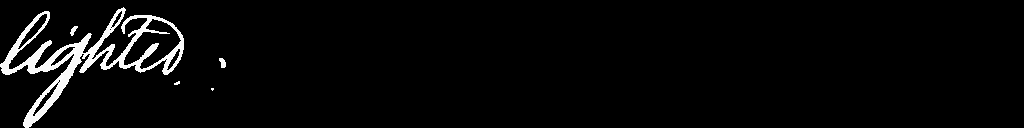

Ground truth: lighted . 
Prediction : Qepled .  




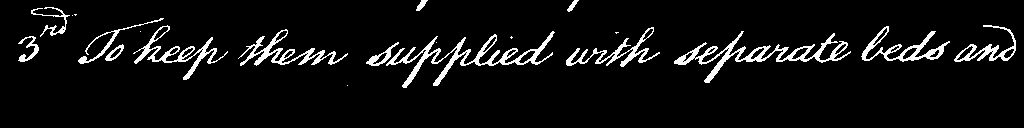

Ground truth: 3rd To keep them supplied with separate beds and
Prediction : 2d Vo keep them suppliced with separate beds and 




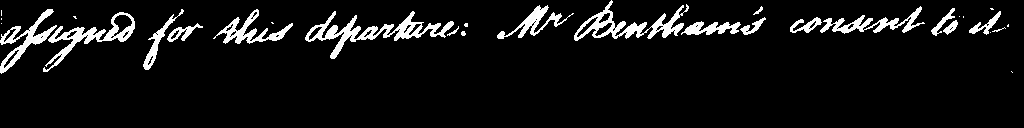

Ground truth: assigned for this departure : Mr Bentham ' s consent to it
Prediction : assigned for this departere : No Unthand consert to id 




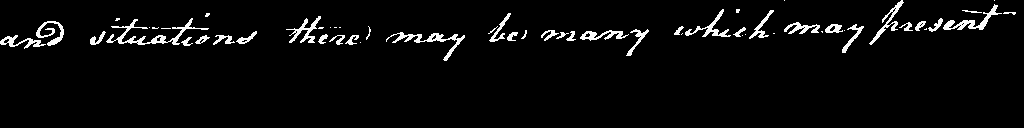

Ground truth: and situations there may be many which may present
Prediction : and situations there may be many which may present 




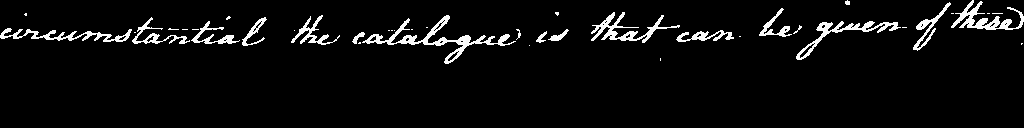

Ground truth: circumstantial the catalogue is that can be given of these
Prediction : circumstantial the catagre is that can be given of those 




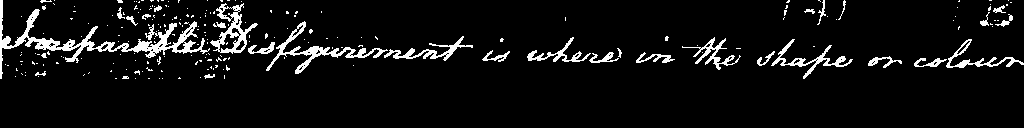

Ground truth: Irreparable Disfigurement is where in the shape or colour
Prediction : Jurepanidle Dussement is where in the shape or colsur 




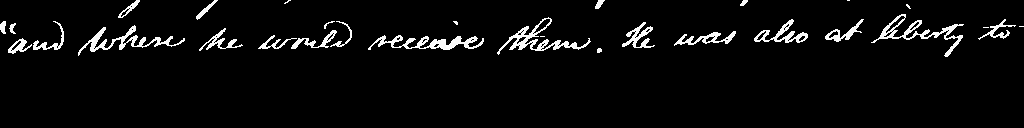

Ground truth:  " and where he would receive them . He was also at liberty to
Prediction :  " there he wnld receive them . the was also at Vlearty to 




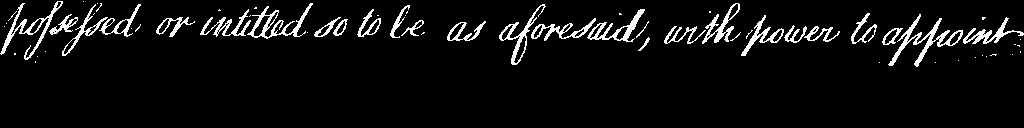

Ground truth: possessed or intitled so to be as aforesaid , with power to appoint
Prediction : pessed or intitled so to be as govesaid , with power to aspsaint 




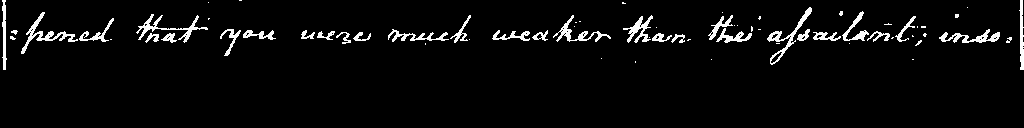

Ground truth: pened that you were much weaker than the assailant ; inso
Prediction : pened that you were much weater than the assailant ; inso 




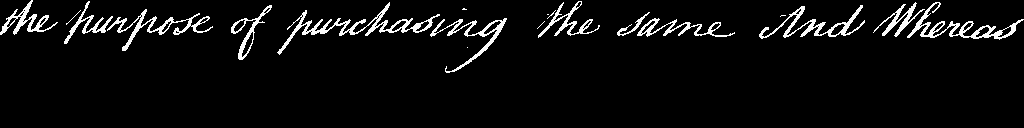

Ground truth: the purpose of purchasing the same And Whereas
Prediction : the purpose of purcharing the same And Whereas 




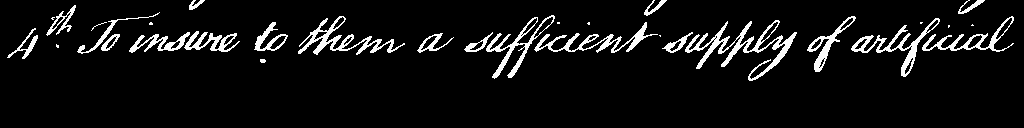

Ground truth: 4th To insure to them a sufficient supply of artificial
Prediction : 15th V insure to them a sufficient sapply of aulfical 




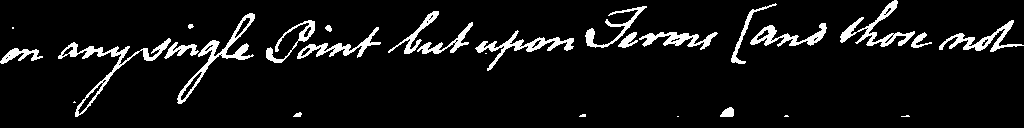

Ground truth: on any single Point but upon Terms ( and those not
Prediction : on ansingle Peint but upon Ferr Ferences ( ans those not 




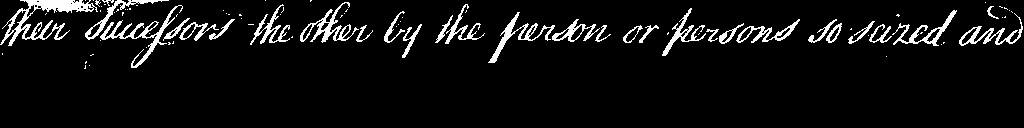

Ground truth:  ( their Successors the other by the person or persons so seized and
Prediction : har Luccessors the other by the persons or persons so sained and 




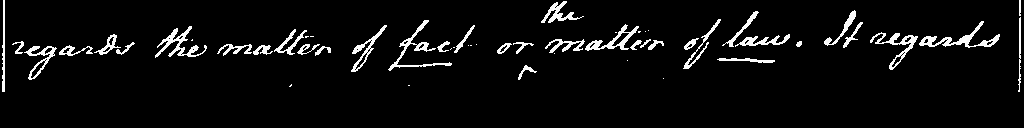

Ground truth: regards the matter of fact or the matter of law . It regards
Prediction : regards the matter of fact or matter of law . Id regards 




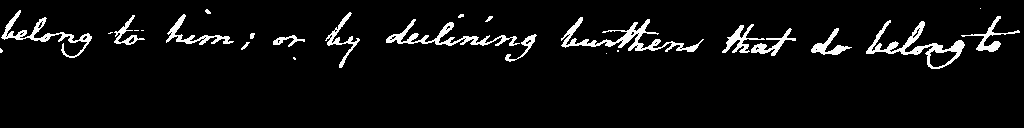

Ground truth: belong to him ; or by declining burthens that do belong to
Prediction : beng to hims or by declining buthens that do beloay to 




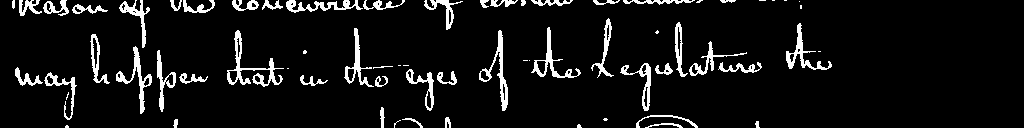

Ground truth: may happen that in the eyes of the Legislature the
Prediction : way beppen that in tho yes of the Legilature the 




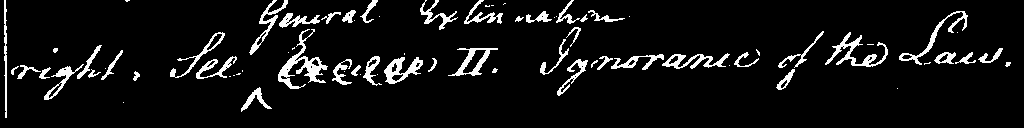

Ground truth: right . See Excuse II . Ignorance of the Law . 
Prediction : right . See Peceale tr vapmorance of the Law .  




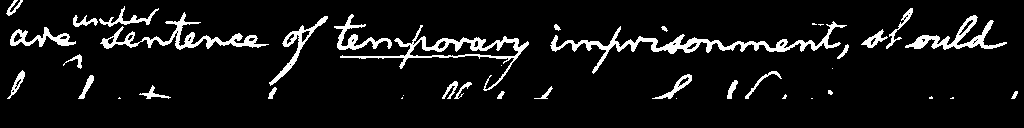

Ground truth: are sentence of temporary imprisonment , should
Prediction : ar . Nentence of temporer imprisonment , it sould 



In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow
 
for i, item in enumerate(imgs[:100]):

    img = item.permute(1,2,0).cpu().numpy().astype(np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    print("Ground truth:",gt[i])
    print("Prediction :", predicts[i], "\n")

For the best results I used the ensemble of two checkpoints of model.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI" -O resnet_second_best.pt && rm -rf /tmp/cookies.txt

In [ ]:
second_model = make_model(100) #I used the vocab size of 100
second_model.load_state_dict(torch.load('resnet_second_best.pt'))
_=second_model.to(device)


In [ ]:
beta = 0.5 #The interpolation parameter    
params1 = model.state_dict()
params2 = second_model.state_dict()
 
dict_params2 = params2
 
for name1, param1 in params1.items():
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(beta*param1.data + (1-beta)*dict_params2[name1].data)
 
model.load_state_dict(dict_params2)

In [ ]:
predicts, gt, imgs = test(model, test_loader, max_text_length)
 
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)


In [ ]:
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))


In [ ]:
l